In [1]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
from multiprocessing import Pool
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
from KDEpy import FFTKDE
from tqdm.auto import tqdm
from math import ceil
import itertools
import scipy
from fast_histogram import histogram2d
import colorcet as cc
import matplotlib.colors as colors
import h5py
import io

lmap = lambda func, *iterable: list(map(func, *iterable))

## Load data

In [2]:
dataset_path = ...

In [3]:
with h5py.File(dataset_path, "r") as f:
    dX = f["filters"][...]

    df_meta_raw = bytearray(f["meta"][...]).decode("utf-8")
    df_meta = pd.read_csv(io.StringIO(df_meta_raw))
    df_meta["filter_ids"] = df_meta["filter_ids"].apply(lambda s: np.arange(int(s.split(":")[0]), 1 + int(s.split(":")[1])))

In [4]:
df_meta = pd.read_hdf(dataset_path, "meta")

## Scale the filters by absolute peak weight

In [5]:
def scale(X):
    den = np.abs(X).max(axis=1)
    den = np.where(den == 0, 1, den)[:, None]
    return X / den

dX_scaled = scale(dX)

## Perform PCA transformation

In [6]:
pca = PCA(n_components=9)
dX_n = pca.fit_transform(dX_scaled)

In [7]:
pca.mean_

array([-0.03198305, -0.03198278, -0.03198291, -0.03198304, -0.03198269,
       -0.03198301, -0.03198298, -0.03198301, -0.0319832 ], dtype=float32)

In [8]:
dX_n_range = (dX_n.min(), dX_n.max())

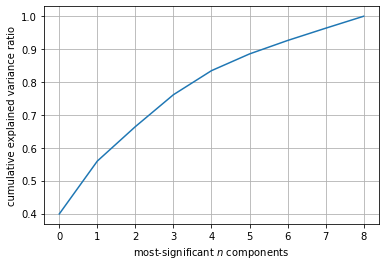

In [9]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel("cumulative explained variance ratio")
plt.xlabel("most-significant $n$ components")
plt.grid()
plt.show()

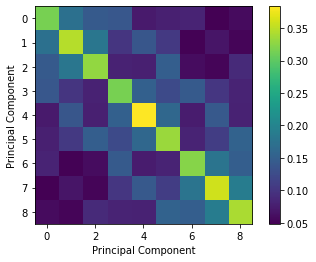

In [10]:
plt.imshow(pca.get_covariance())
plt.xlabel("Principal Component")
plt.ylabel("Principal Component")
plt.colorbar()
plt.show()

## Compute *subset* eigenimages and explained variance ratio

To compute the eigenimages of different splits, just select the filter_ids from the meta table and compute a PCA on the subset.
As an example we select all filters with datatype "formula" but you can change this to any selection you'd like.

In [11]:
filter_mask = np.hstack(df_meta[df_meta.Datatype == "formula"].filter_ids)
subset_pca = PCA(n_components=9)
subset_pca.fit(dX_scaled[filter_mask])

PCA(n_components=9)

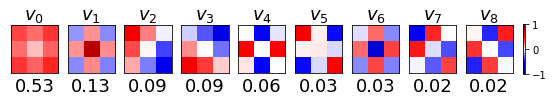

In [12]:
fig, axes = plt.subplots(1, 9, figsize=(9, 1))
for i, ax in enumerate(axes):
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    im = ax.imshow(subset_pca.components_[i].reshape(3, 3), vmin=-1, vmax=1, cmap="seismic")
    ax.set_title(f"$v_{i}$", fontweight='bold', fontsize=18)
    ax.set_xlabel(f"{subset_pca.explained_variance_ratio_[i]:.2f}", fontsize=18)
    
cb_ax = fig.add_axes([0.83, 0.15, 0.1, 0.7])    
cb_ax.axis("off")
fig.colorbar(im, ax=cb_ax)
plt.show()

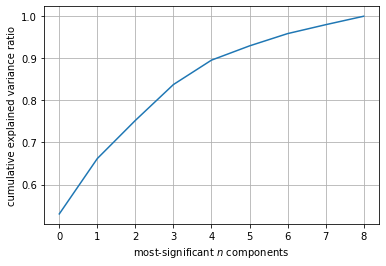

In [13]:
plt.plot(np.cumsum(subset_pca.explained_variance_ratio_))
plt.ylabel("cumulative explained variance ratio")
plt.xlabel("most-significant $n$ components")
plt.grid()
plt.show()

## Generate ridge plots

In [14]:
def ridge_plot(X, xrange, shape, row_labels=None, col_labels=None, figsize=(40, 10)):
    gs = grid_spec.GridSpec(*shape)
    fig = plt.figure(figsize=figsize)

    ax_objs = []
    for i in tqdm(range(shape[0])):
        for j in range(shape[1]):

            data = X[i][j]            
            dx, dy = FFTKDE(kernel="gaussian", bw='silverman').fit(data).evaluate()

            color = f"C{i%10}"
            
            # creating new axes object
            ax_objs.append(fig.add_subplot(gs[i:i+1, j:j+1]))

            # plotting the distribution
            ax_objs[-1].plot(dx, dy, color="#f0f0f0", lw=1)
            ax_objs[-1].fill_between(dx, dy, alpha=.7, color=color)

            # setting uniform x and y lims
            ax_objs[-1].set_xlim(*xrange)

            # make background transparent
            ax_objs[-1].patch.set_alpha(0)

            # remove borders, axis ticks, and labels
            ax_objs[-1].set_yticklabels([])
            ax_objs[-1].set_yticks([])
            ax_objs[-1].set_ylim([0, None])

            for s in ["top", "right", "left", "bottom"]:
                ax_objs[-1].spines[s].set_visible(False)
            
            if i == shape[0] - 1:
                ax_objs[-1].tick_params(direction="inout")
                ax_objs[-1].spines["bottom"].set_visible(True)
                
                if col_labels is not None:
                    ax_objs[-1].set_xlabel(col_labels[j])
            else:
                ax_objs[-1].set_xticks([])
                ax_objs[-1].set_xticklabels([])

            if j == 0 and row_labels is not None:
                ax_objs[-1].text(xrange[0] - 0.1, 0, row_labels[i], ha="right", wrap=True, color=color)

    gs.update(hspace=-0.5)

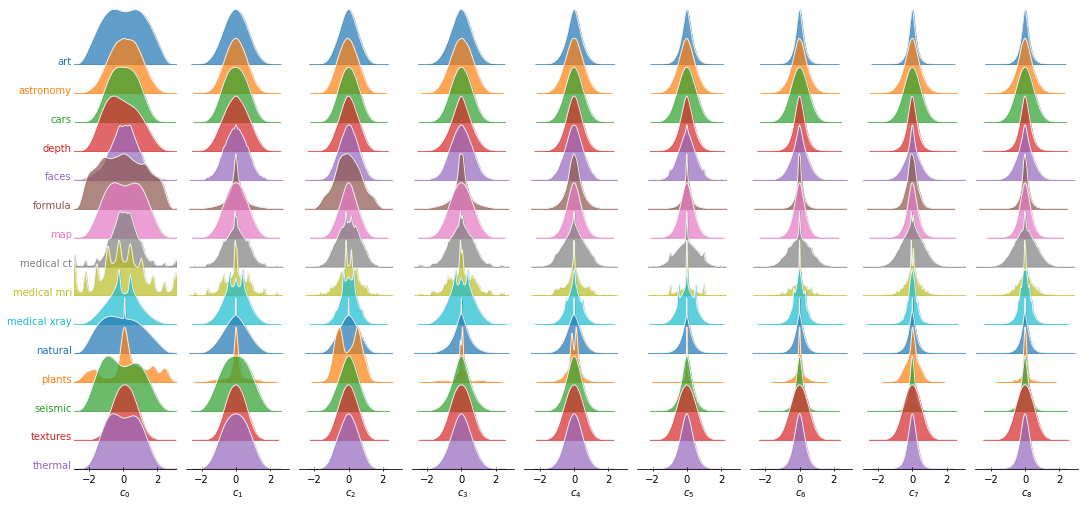

In [15]:
datatype_distributions = df_meta.groupby("Datatype").filter_ids.apply(lambda x: dX_n[np.hstack(x)].T)

figsize=(18, 1 + 0.5 * len(datatype_distributions))
ridge_plot(datatype_distributions.values, xrange=dX_n_range, 
           shape=(len(datatype_distributions), 9), 
           row_labels=datatype_distributions.index, 
           col_labels=lmap(lambda i: f"$c_{i}$", range(9)), 
           figsize=figsize)
plt.subplots_adjust(hspace=0, wspace=0.1)
plt.show()

## Generate KL-matrices and boxplots

In [18]:
def kl_sym(p, q):
    return scipy.stats.entropy(p, q) + scipy.stats.entropy(q, p)

def nd_kl_sym(p, q, weights=None):
    if type(p) is not list and len(p.shape) == 1:
        return kl_sym(p, q)
    else:
        return np.sum(lmap(lambda i: weights[i] * kl_sym(p[i], q[i]), range(len(p))))

def get_kl_matrix(data, bins, x_range, weights=None):
    d = len(data)
    kl_matrix = np.zeros((d, d))
    lookup = dict()
    for p, q in tqdm(itertools.product(range(d), repeat=2), total=d**2):
        if p not in lookup:
            lookup[p] = get_nd_discrete_probability_distribution(data[p], x_range, bins)
        if q not in lookup:
            lookup[q] = get_nd_discrete_probability_distribution(data[q], x_range, bins)
                
        kl_matrix[p, q] = nd_kl_sym(lookup[p], lookup[q], weights=weights)
    return kl_matrix

def get_discrete_probability_distribution(X, _range, bins):
    v, _ = np.histogram(X, range=_range, bins=bins, density=True)  # density will not sum to 1 but help to not underflow eps during normalization
    v = v.astype(np.double) 
    v[v == 0] = np.finfo(np.float32).eps
    v = v / np.sum(v)
    return v

def get_nd_discrete_probability_distribution(X, _range, bins):
    if type(X) is not list and len(X.shape) == 1:
        return get_discrete_probability_distribution(X, _range, bins)
    else:
        dims = list()
        for x in X:
            v = get_discrete_probability_distribution(x, _range, bins)
            dims.append(v)
        return np.vstack(dims)

def kl_plot(s, figsize=(10, 10), ax=None, sort=True, **kwargs):
    created = False
    if ax is None:
        created = True
        plt.figure(figsize=figsize)
        ax = plt.gca()
    
    img = get_kl_matrix(s.values, **kwargs)
    labels = s.index
    if sort:
        sort_index = np.argsort(np.mean(img, axis=0))
        img = img[sort_index][:, sort_index]
        labels = labels[sort_index]
    
    cim = ax.imshow(img, cmap=cc.cm["fire"])
    ax.set_xticks(range(len(s)))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticks(range(len(s)))
    ax.set_yticklabels(labels, rotation=0)
    
    if created:
        plt.colorbar(cim)
    
    return ax, img

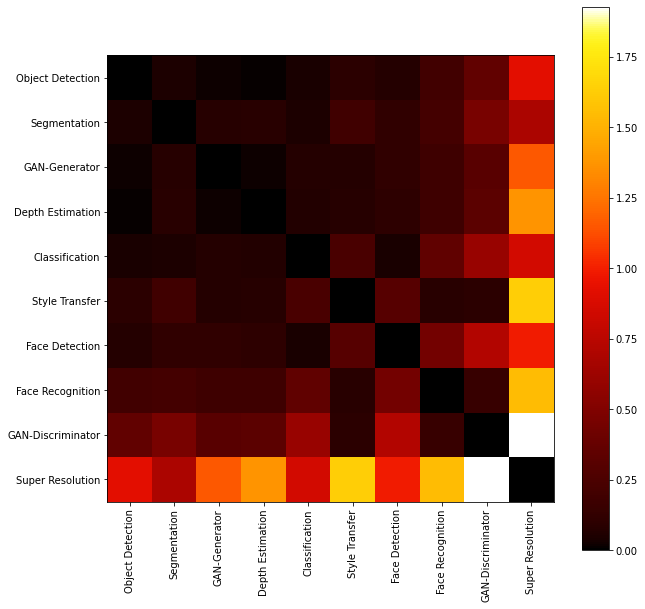

In [19]:
task_distributions = df_meta.groupby("Task").filter_ids.apply(lambda x: dX_n[np.hstack(x)].T)
axes, kl_mat = kl_plot(task_distributions, x_range=dX_n_range, bins=70, weights=pca.explained_variance_ratio_, sort=True)
plt.show()

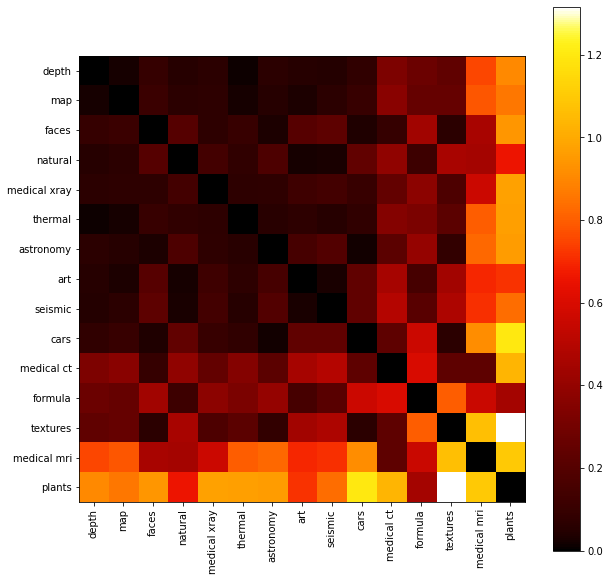

In [20]:
datatype_distributions = df_meta.groupby("Datatype").filter_ids.apply(lambda x: dX_n[np.hstack(x)].T)
axes, kl_mat = kl_plot(datatype_distributions, x_range=dX_n_range, bins=70, weights=pca.explained_variance_ratio_, sort=True)
plt.show()

To compare KL between different splits it's important to create histograms with similar range and bins for all splits. The range is the minimum and maximum over all splits (or just use dX_n_range which is the range of all coefs). We used 70 bins to represent the scaled filters.

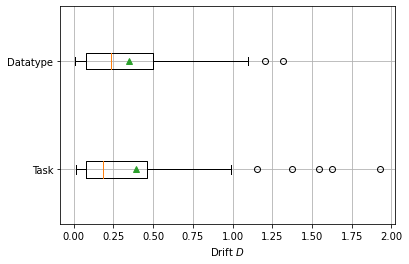

In [21]:
labels = []
kl_values = []
for grouping in ["Task", "Datatype"]:
    coef_groups = df_meta.groupby(grouping).filter_ids.apply(lambda x: dX_n[np.hstack(x)].T)
    kl_mat = get_kl_matrix(coef_groups.values, weights=pca.explained_variance_ratio_, x_range=dX_n_range, bins=70)
    kl_values.append(kl_mat[np.triu_indices(len(kl_mat), 1)])
    labels.append(grouping)
    
plt.boxplot(kl_values, showmeans=True, vert=False)
plt.gca().set_yticks(range(1, len(labels) + 1))
plt.gca().set_yticklabels(labels)
plt.grid()
plt.xlabel("Drift $D$")
plt.show()

## Scatterplots

In [22]:
def scatter(X, Y, bounds, bins, vmin=10e-6):
    cmap = cc.cm["fire"].copy()
    cmap.set_bad(cmap.get_under())
    
    h = histogram2d(X, Y, range=bounds, bins=bins)
    h = (h / h.max()).T
    
    ax = plt.gca()
    ax.imshow(h, cmap=cmap, norm=colors.LogNorm(vmin=vmin, vmax=1))
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    return ax

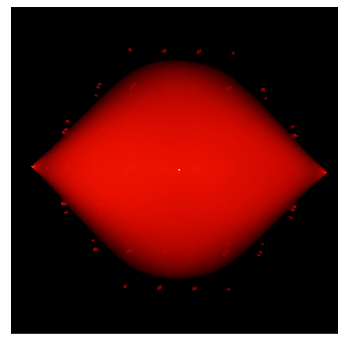

In [23]:
plt.figure(figsize=(6, 6))
axes = scatter(dX_n[:,0], dX_n[:,1], bounds=[[-3.3, 3.3], [-3.3, 3.3]], bins=512)
plt.show()